In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import wasserstein_distance, norm
from scipy.optimize import minimize_scalar
from sklearn.neighbors import KernelDensity
from sklearn.metrics import root_mean_squared_error
from KDEpy import FFTKDE
from tqdm import tqdm
import pickle
import os
import sys

sys.path.append(os.path.abspath(os.path.join("..")))

import engine
import visual
import utils


pygame 2.5.2 (SDL 2.28.3, Python 3.12.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Procedures

In [2]:
def compute_kdes(df, x_label, bw, kde_method="sklearn"):

    """
    Create a dictionary representing the kernel density estimate for each trial and each hole.
    Args:
    - df: DataFrame containing the data
    - x_label: Column name representing the samples
    - bw: Bandwidth for the KDE
    - kde_method: Method to use for KDE ("sklearn" or "FFTKDE")
    Output:
    - kde_dict: Dictionary containing the KDE for each world and hole
    """
    
    kde_grid = np.arange(600)
    
    world_set = df["world"].unique()
    holes = [1,2,3]
    
    kde_dict = {}
    
    for world in world_set:
        world_dict = {}
        
        for hole in holes:
            
            samples = df[(df["world"] == world) &
                         (df["hole"] == hole)][x_label].to_numpy()
            
            if kde_method == "sklearn":
                kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(samples[:,np.newaxis])
                dist = np.exp(kde.score_samples(kde_grid[:,np.newaxis]))
            elif kde_method == "FFTKDE":
                kde = FFTKDE(kernel="gaussian", bw=bw).fit(samples)
                dist = kde.evaluate(kde_grid)
            else:
                raise Exception(f"KDE method {kde_method} not implemented.")
            
            world_dict[hole] = dist
            
        kde_dict[world] = world_dict
        
    return kde_dict

# Not really response_array. This is a model array.
def make_kdes(response_array, bw, kde_method="sklearn"):

    """
    Create an array of kernel density estimates (KDEs) for each trial in the response array.
    Args:
    - response_array: Array containing the model responses
    - bw: Bandwidth for the KDE
    - kde_method: Method to use for KDE ("sklearn" or "FFTKDE")
    Output:
    - model_kdes: Array of KDEs for each trial
    """

    nrows = response_array.shape[0]
    model_kdes = []

    for i in range(nrows):
        samples = response_array[i]

        if kde_method == "FFTKDE":
            kde_obj = FFTKDE(kernel="gaussian", bw=bw).fit(samples)
            kde = kde_obj.evaluate(np.arange(600))
        elif kde_method == "sklearn":
            kde = KernelDensity(kernel="gaussian", bandwidth=bw).fit(samples[:,np.newaxis])
        else:
            raise Exception(f"KDE method {kde_method} not implemented.")

        model_kdes.append(kde)

    return np.stack(model_kdes) if kde_method == "FFTKDE" else model_kdes


def ave_emd(model_kdes, human_kdes, world_set, model_type="noisy_sim"):

    """
    Compute the average Earth Mover's Distance (EMD) between model and human KDEs.
    Args:
    - model_kdes: KDEs for the model (kde_dict)
    - human_kdes: KDEs for the human (kde_dict)
    - world_set: Set of worlds to consider
    - model_type: Type of model being evaluated
    Output:
    - emd: Average EMD value
    """

    emd = 0

    for world in world_set:
        for hole in [1,2,3]:
            hist1 = human_kdes[world][hole]
            if model_type in ["noisy_sim", "ground_truth", "linear", "mlp", "cnn"]:
                assert type(model_kdes) == dict
                hist2 = model_kdes[world][hole]
            elif model_type == "below_hole":
                assert type(model_kdes) == list
                hist2 = model_kdes[hole-1]
            else:
                raise Exception(f"Model type {model_type} not implemented.")
            
            emd += wasserstein_distance(np.arange(600), np.arange(600), u_weights=hist1, v_weights=hist2)

    return emd / (3 * len(world_set))

def compute_likelihood(model_dists, response_array, model):

    """
    Compute the likelihood of participant responses given the model distributions.
    Args:
    - model_dists: The model distributions (KDEs) for each trial represented as a list of distribution objects
    - response_array: The participant responses for each trial
    - model: The type of model being evaluated
    Output:
    - log_prob: The sum log probability of the participant responses given the model distributions
    """

    num_trials = response_array.shape[0]

    if model == "noisy_sim_FFTKDE":
        row_ind = np.arange(num_trials)[:, np.newaxis]
        log_prob = np.sum(np.log(model_dists[row_ind, response_array]))

    elif model in ["below_hole", "ground_truth", "noisy_sim_sklearn"]:

        log_prob = 0

        for i in range(num_trials):
            response = response_array[i]

            if model == "below_hole":
                dist = model_dists[i%3]
                log_prob += np.sum(dist.logpdf(response))
            elif model == "ground_truth":
                dist = model_dists[i]
                log_prob += np.sum(dist.logpdf(response))
            elif model == "noisy_sim_sklearn":
                dist = model_dists[i]
                log_prob += np.sum(dist.score_samples(response.reshape(-1,1)))

    else:
        raise Exception(f"Model {model} not implemented.")
    
    return log_prob

def compute_ns_grid(file_list, bw_range, response_array, world_nums, kde_method="sklearn"):

    """
    Create a dataframe representing the log probability of participant responses on each trial for each parameter setting
    Args:
    - file_list: List of file names to process
    - bw_range: Range of bandwidth values to test
    - response_array: Array of participant responses
    - world_nums: List of world numbers (three holes per world)
    - kde_method: Method to use for KDE ("sklearn" or "FFTKDE")
    Output:
    - df: DataFrame containing the log probabilities for each parameter setting on all trials
    """

    grid_dict = {
        "dn": [],
        "cm": [],
        "csd": [],
        "bw": [],
        "world": [],
        "hole": [],
        "trial_ind": [],
        "log_prob": []
    }

    ntrials = response_array.shape[0]
    
    if kde_method == "FFTKDE":
        response_array = np.round(response_array).astype(int)
        trial_inds = np.arange(ntrials)[:, np.newaxis]

    for file in tqdm(file_list):
        file_spl = file.split("_")
        dn = file_spl[1]
        cm = file_spl[4]
        csd = file_spl[7]

        model_df = pd.read_csv("grid_search/" + file)
        model_arr = convert_df_to_arr(model_df, "x_pos")

        for bw in bw_range:
            model_kdes = make_kdes(model_arr, bw, kde_method)
            if kde_method == "FFTKDE":
                log_probs = np.sum(np.log(model_kdes[trial_inds, response_array]), axis=1)

                grid_dict["dn"].extend([dn] * ntrials)
                grid_dict["cm"].extend([cm] * ntrials)
                grid_dict["csd"].extend([csd] * ntrials)
                grid_dict["bw"].extend([bw] * ntrials)
                grid_dict["world"].extend(np.repeat(world_nums, 3))
                grid_dict["hole"].extend(np.tile([1,2,3], len(world_nums)))
                grid_dict["trial_ind"].extend(np.arange(ntrials//3))
                grid_dict["log_prob"].extend(log_probs)


            elif kde_method == "sklearn":
                for trial in range(ntrials):
                    tr_kde = model_kdes[trial]
                    log_prob = tr_kde.score_samples(response_array[trial].reshape(-1,1)).sum()

                    grid_dict["dn"].append(dn)
                    grid_dict["cm"].append(cm)
                    grid_dict["csd"].append(csd)
                    grid_dict["bw"].append(bw)
                    grid_dict["world"].append(world_nums[trial//3])
                    grid_dict["hole"].append(trial%3 + 1)
                    grid_dict["trial_ind"].append(trial//3)
                    grid_dict["log_prob"].append(log_prob)

            else:
                raise Exception(f"KDE method {kde_method} not implemented.")
            
    return pd.DataFrame(grid_dict)

def create_below_hole_dists(sd, hole_pos):

    """
    Create the distribution objects for the below hole model.
    Args:
    - sd: Standard deviation for the normal distributions
    - hole_pos: List of hole positions
    Output:
    - List of normal distributions for each hole
    """

    hole1_dist = norm(hole_pos[0], sd)
    hole2_dist = norm(hole_pos[1], sd)
    hole3_dist = norm(hole_pos[2], sd)

    return [hole1_dist, hole2_dist, hole3_dist]

def create_gt_dists(sd, gt_list):
    """
    Create the distribution objects for the ground truth model.
    Args:
    - sd: Standard deviation for the normal distributions
    - gt_list: List of ground truth positions
    Output:
    - List of normal distributions for each hole on each world
    """

    gt_dists = []

    for hole_pos in gt_list:
        hole_dist = norm(hole_pos, sd)
        gt_dists.append(hole_dist)

    return gt_dists

def create_gt_pdfs(sd, gt_dict, world_set):
    """
    Create the PDF representations for the ground truth model.
    Args:
    - sd: Standard deviation for the normal distributions
    - gt_dict: Dictionary containing ground truth positions for each world and hole
    - world_set: Set of world numbers
    Output:
    - Dictionary of PDFs for each world and hole
    """

    gt_pdfs = {}

    for world in world_set:
        world_dict = {}

        for hole in [1,2,3]:
            hole_pos = gt_dict[world][hole]
            hole_pdf = norm(hole_pos, sd).pdf(np.arange(600))
            world_dict[hole] = hole_pdf

        gt_pdfs[world] = world_dict

    return gt_pdfs

def convert_df_to_arr(df, x_name):
    """
    Convert a df representation of predictions to a 2D numpy array.
    Args:
    - df: DataFrame containing the predictions
    - x_name: Name of the column to extract
    Output:
    - 2D numpy array representation of the predictions
    """
    grouped = df.groupby(["world", "hole"])[x_name].apply(list).reset_index()
    arr = np.stack(grouped[x_name].values)
    return arr



# Load Data

In [3]:
human_data = pd.read_csv("../../../data/human_data/prediction/prediction_long.csv").drop("Unnamed: 0", axis=1)
grouped = human_data.groupby(['world', 'hole'])['response'].apply(list).reset_index()
response_array = np.stack(grouped["response"].values)
human_mean_resp = response_array.mean(axis=1)
response_arr_ind = np.round(response_array).astype(int)

In [4]:
world_nums = human_data["world"].unique()
world_nums

array([  2,   6,   9,  10,  12,  13,  14,  16,  20,  26,  27,  32,  38,
        42,  45,  47,  48,  50,  56,  59,  62,  70,  74,  80,  82,  84,
        86,  90,  91,  92,  94,  99, 104, 105, 109, 111, 112, 113, 115,
       118])

In [5]:
human_kdes = compute_kdes(human_data, "response", 20, kde_method="FFTKDE")

In [6]:
def bootstrap_ci(data, n_boot=1000, ci=95):
    """Compute bootstrapped confidence interval for the mean."""
    boot_means = []
    for _ in range(n_boot):
        sample = np.random.choice(data, size=len(data), replace=True)
        boot_means.append(np.mean(sample))
    lower = np.percentile(boot_means, (100 - ci) / 2)
    upper = np.percentile(boot_means, 100 - (100 - ci) / 2)
    return lower, upper

np.random.seed(1)
# Group by 'world' and 'hole', compute mean and bootstrapped CI
results = []
for (world, hole), group in human_data.groupby(['world', 'hole']):
    mean_resp = group['response'].mean()
    lower, upper = bootstrap_ci(group['response'].values)
    results.append({'world': world, 'hole': hole, 'mean_response': mean_resp, 'ci_lower': lower, 'ci_upper': upper})

df_mean_ci = pd.DataFrame(results)

df_mean_ci.to_csv("human_mean_ci.csv", index=False)

# Below Hole Model

In [7]:
# Get the unity hole positions
world = utils.load_trial(2, experiment="prediction", hole=1)
unity_world = visual.unity_transform_trial(world, generate_shapes=True)
hole_pos = unity_world["hole_positions"]

In [8]:
below_hole_likes = []
for sd in np.arange(50,301):
    below_hole_dists = create_below_hole_dists(sd, hole_pos)
    below_hole_like = -compute_likelihood(below_hole_dists, response_array, model="below_hole")
    below_hole_likes.append(below_hole_like)


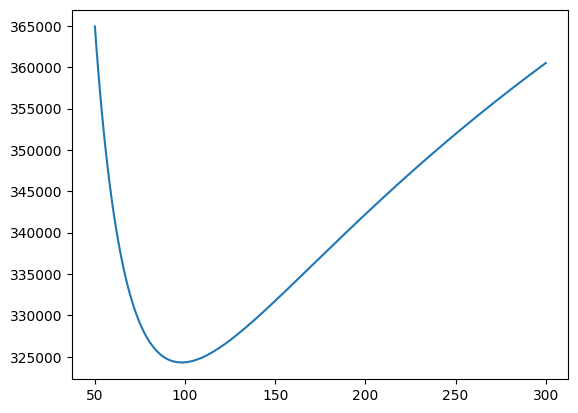

In [9]:
plt.plot(np.arange(50,301), below_hole_likes)

In [10]:
# create below hole function to optimize
def below_hole_neg_like(sd, response_array):
    below_hole_dists = create_below_hole_dists(sd, hole_pos)
    below_hole_neg_like = -compute_likelihood(below_hole_dists, response_array, model="below_hole")
    return below_hole_neg_like

In [11]:
full_opt = minimize_scalar(below_hole_neg_like, args=(response_array), bounds=[1, 300])
full_opt_sd = full_opt.x
print("Optimal SD:", np.round(full_opt_sd, decimals=2))
print("Optimal Like:", np.round(-full_opt.fun, decimals=2))

Optimal SD: 98.16
Optimal Like: -324298.71


In [12]:
below_hole_dists = create_below_hole_dists(full_opt_sd, hole_pos)
below_hole_dists = np.stack([dist.pdf(np.arange(600)) for dist in below_hole_dists])
below_hole_dists

array([[1.24038546e-03, 1.25994199e-03, 1.27967403e-03, ...,
        1.35107421e-07, 1.28992446e-07, 1.23141454e-07],
       [3.80781484e-05, 3.92803455e-05, 4.05162930e-05, ...,
        4.17867923e-05, 4.05162930e-05, 3.92803455e-05],
       [1.17543659e-07, 1.23141454e-07, 1.28992446e-07, ...,
        1.29958022e-03, 1.27967403e-03, 1.25994199e-03]])

In [13]:
below_hole_kde_dict = {}

for world in world_nums:
    below_hole_kde_dict[world] = {}
    for hole in [1,2,3]:
        below_hole_kde_dict[world][hole] = below_hole_dists[hole-1]
# below_hole_kde_dict

In [14]:
with open("saved_model_pred/below_hole_kde_dict.pkl", "wb") as f:
    pickle.dump(below_hole_kde_dict, f)

# Ground Truth Model

In [15]:
gt_list = []
gt_dict = {}

for world_num in world_nums:
    world_dict = {}
    for hole in [1,2,3]:
        world = utils.load_trial(world_num, experiment="prediction", hole=hole, drop_noise=0.0, col_mean=1.0, col_sd=0.0)
        world["hole_dropped_into"] = hole-1
        sim_data = engine.run_simulation(world, convert_coordinates=True)
        x_pos = sim_data["ball_position"][-1]["x"]
        gt_list.append(x_pos)
        world_dict[hole] = x_pos
    gt_dict[world_num] = world_dict

gt_list = np.array(gt_list)


In [16]:
gt_likes = []
for sd in np.arange(50, 301):
    gt_dists = create_gt_dists(sd, gt_list)
    gt_like = -compute_likelihood(gt_dists, response_array, model="ground_truth")
    gt_likes.append(gt_like)

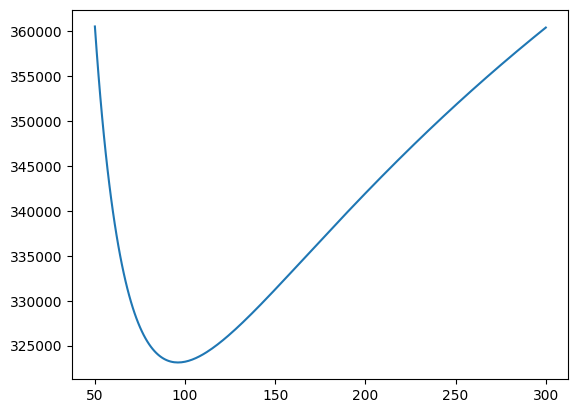

In [17]:
plt.plot(np.arange(50,301), gt_likes)

In [18]:
def gt_neg_like(sd, response_array, gt_list):
    gt_dists = create_gt_dists(sd, gt_list)
    gt_neg_like = -compute_likelihood(gt_dists, response_array, model="ground_truth")
    return gt_neg_like

In [19]:
full_opt = minimize_scalar(gt_neg_like, args=(response_array, gt_list), bounds=[1, 300])
full_opt_sd = full_opt.x
print("Optimal SD:", np.round(full_opt_sd, decimals=2))
print("Optimal Like:", np.round(-full_opt.fun, decimals=2))

Optimal SD: 96.05
Optimal Like: -323127.43


In [20]:
gt_dists = create_gt_dists(full_opt_sd, gt_list)
gt_dists = np.stack([dist.pdf(np.arange(600)) for dist in gt_dists])
gt_dists

array([[1.95397898e-03, 1.97901380e-03, 2.00415213e-03, ...,
        1.64949352e-08, 1.56594941e-08, 1.48647554e-08],
       [1.36590732e-09, 1.44578112e-09, 1.53015983e-09, ...,
        3.13202798e-03, 3.10745702e-03, 3.08274468e-03],
       [3.89702890e-08, 4.09700079e-08, 4.30676721e-08, ...,
        1.55112458e-03, 1.52854166e-03, 1.50612428e-03],
       ...,
       [3.08383489e-06, 3.20797967e-06, 3.33676042e-06, ...,
        2.22648866e-04, 2.17099667e-04, 2.11665829e-04],
       [3.16351757e-05, 3.26789605e-05, 3.37535257e-05, ...,
        3.48596468e-05, 3.37535257e-05, 3.26789605e-05],
       [7.55771779e-08, 7.93398809e-08, 8.32808877e-08, ...,
        1.26261027e-03, 1.24241982e-03, 1.22241973e-03]])

In [21]:
gt_kde_dict = {}

for i, world_num in enumerate(world_nums):
    gt_kde_dict[world_num] = {}
    for hole in [1,2,3]:
        gt_kde_dict[world_num][hole] = gt_dists[i*3 + hole - 1]

gt_kde_dict

{2: {1: array([1.95397898e-03, 1.97901380e-03, 2.00415213e-03, 2.02938981e-03,
         2.05472258e-03, 2.08014611e-03, 2.10565597e-03, 2.13124765e-03,
         2.15691659e-03, 2.18265809e-03, 2.20846743e-03, 2.23433976e-03,
         2.26027020e-03, 2.28625376e-03, 2.31228538e-03, 2.33835994e-03,
         2.36447225e-03, 2.39061702e-03, 2.41678892e-03, 2.44298255e-03,
         2.46919242e-03, 2.49541301e-03, 2.52163870e-03, 2.54786385e-03,
         2.57408273e-03, 2.60028957e-03, 2.62647852e-03, 2.65264372e-03,
         2.67877921e-03, 2.70487902e-03, 2.73093711e-03, 2.75694740e-03,
         2.78290378e-03, 2.80880009e-03, 2.83463011e-03, 2.86038763e-03,
         2.88606637e-03, 2.91166004e-03, 2.93716231e-03, 2.96256682e-03,
         2.98786720e-03, 3.01305705e-03, 3.03812996e-03, 3.06307950e-03,
         3.08789923e-03, 3.11258268e-03, 3.13712340e-03, 3.16151493e-03,
         3.18575079e-03, 3.20982452e-03, 3.23372965e-03, 3.25745974e-03,
         3.28100832e-03, 3.30436898e-03, 3.32

In [22]:
with open("saved_model_pred/gt_kde_dict.pkl", "wb") as f:
    pickle.dump(gt_kde_dict, f)

# Noisy Sim Models

In [23]:
model_files = [file for file in os.listdir("grid_search") if "prediction" in file]

## Drop Noise Only

In [24]:
dno_files = sorted([file for file in model_files if "1.0_col_mean_0.0_col_sd" in file])
dno_files

['prediction_0.0_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.1_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.2_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.3_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.4_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.5_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.6_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.7_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.8_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_0.9_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv',
 'prediction_1.0_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv']

In [25]:
def sim_neg_like(bw, model_arr, response_arr, kde_method="sklearn", model="noisy_sim_sklearn"):
    model_kde = make_kdes(model_arr, bw, kde_method=kde_method)
    sim_neg_like = -compute_likelihood(model_kde, response_arr, model=model)
    return sim_neg_like

In [26]:
opts = []
response_array_ind = np.round(response_array).astype(int)
for i, file in enumerate(dno_files):
    df = pd.read_csv(f"grid_search/{file}").drop("Unnamed: 0", axis=1)
    model_arr = convert_df_to_arr(df, "x_pos")
    opt = minimize_scalar(sim_neg_like, bracket=[30, 150], args=(model_arr, response_array_ind, "sklearn", "noisy_sim_sklearn"))
    opts.append((i/10,opt))

In [27]:
opts.sort(key=lambda x: x[1].fun)

In [28]:
opts[0]

(0.3,
  message: 
           Optimization terminated successfully;
           The returned value satisfies the termination criteria
           (using xtol = 1.48e-08 )
  success: True
      fun: 315518.73188917234
        x: 66.73658170623804
      nit: 15
     nfev: 18)

In [29]:
df = pd.read_csv(f"grid_search/{dno_files[3]}").drop("Unnamed: 0", axis=1)
model_arr = convert_df_to_arr(df, "x_pos")

In [30]:
sim_likes = []
for bw in np.arange(30, 151):
    sim_like = sim_neg_like(bw, model_arr, response_array_ind)
    sim_likes.append(sim_like)

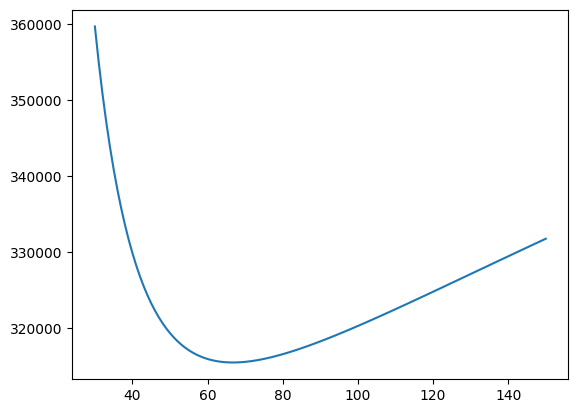

In [31]:
plt.plot(np.arange(30,151), sim_likes)

In [32]:
print("Top Drop Noise Only Model:")
print(dno_files[3])

Top Drop Noise Only Model:
prediction_0.3_drop_noise_1.0_col_mean_0.0_col_sd_100_sims.csv


## Col Noise Only

In [33]:
cno_files = sorted([file for file in model_files if "0.0_drop_noise" in file])
cno_files

['prediction_0.0_drop_noise_0.0_col_mean_0.1_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.2_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.3_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.4_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.5_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.6_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.7_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.8_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_0.9_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.0_col_mean_1.0_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.1_col_mean_0.1_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.1_col_mean_0.2_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.1_col_mean_0.3_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.1_col_mean_0.4_col_sd_100_sims.csv',
 'prediction_0.0_drop_noise_0.1_col_mean_0.5_col_sd_100_sims.c

In [34]:
with open("saved_model_pred/col_noise_only_opt.pkl", "rb") as f:
    opts_cno = pickle.load(f)

# opts_cno = []
# for file in tqdm(cno_files):
#     file_split = file.split("_")
#     col_mean = float(file_split[4])
#     col_split = float(file_split[7])

#     df = pd.read_csv(f"grid_search/{file}").drop("Unnamed: 0", axis=1)
#     model_arr = convert_df_to_arr(df, "x_pos")
#     opt = minimize_scalar(sim_neg_like, bounds=[30, 150], args=(model_arr, response_array_ind, "sklearn", "noisy_sim_sklearn"))
#     opts_cno.append((col_mean, col_split, opt))

# opts_cno.sort(key=lambda x: x[2].fun)

# with open("saved_model_pred/col_noise_only_opt.pkl", "wb") as f:
#     pickle.dump(opts_cno, f)

In [35]:
opts_cno[0]

(0.0,
 0.6,
  message: Solution found.
  success: True
   status: 0
      fun: 308231.8107169336
        x: 66.92042402091042
      nit: 12
     nfev: 12)

In [36]:
df = pd.read_csv(f"grid_search/prediction_0.0_drop_noise_{opts_cno[0][0]}_col_mean_{opts_cno[0][1]}_col_sd_100_sims.csv").drop("Unnamed: 0", axis=1)
model_arr = convert_df_to_arr(df, "x_pos")

In [37]:
sim_likes = []
for bw in np.arange(30, 151):
    sim_like = sim_neg_like(bw, model_arr, response_array_ind)
    sim_likes.append(sim_like)

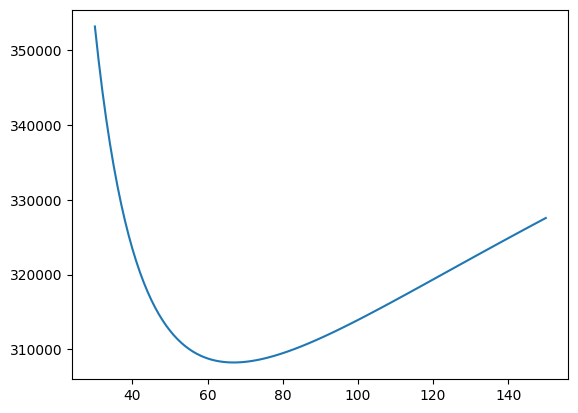

In [38]:
plt.plot(np.arange(30,151), sim_likes)

In [39]:
print("Top Collision Noise Only Model:")
print(f"prediction_0.0_drop_noise_{opts_cno[0][0]}_col_mean_{opts_cno[0][1]}_col_sd_100_sims.csv")

Top Collision Noise Only Model:
prediction_0.0_drop_noise_0.0_col_mean_0.6_col_sd_100_sims.csv


## Noisy Sim

In [40]:
len(os.listdir("grid_search"))
model_files = [file for file in os.listdir("grid_search") if "prediction" in file]

In [41]:
len(model_files)

1221

In [42]:
# Takes roughly 2 hours to run. Optimal phys params end up being 0.3, 0.0, 0.7 with bw ~36
with open("saved_model_pred/noisy_sim_opt.pkl", "rb") as f:
    opts_ns = pickle.load(f)

# opts_ns = []

# for file in tqdm(model_files):
#     file_split = file.split("_")
#     drop_noise = float(file_split[1])
#     col_mean = float(file_split[4])
#     col_sd = float(file_split[7])

#     df = pd.read_csv(f"grid_search/{file}").drop("Unnamed: 0", axis=1)
#     model_arr = convert_df_to_arr(df, "x_pos")
#     opt = minimize_scalar(sim_neg_like, bounds=[1, 150], args=(model_arr, response_array_ind, "sklearn", "noisy_sim_sklearn"))
#     opts_ns.append((drop_noise, col_mean, col_sd, opt))

# opts_ns.sort(key=lambda x: x[3].fun)

# with open("saved_model_pred/noisy_sim_opt.pkl", "wb") as f:
    # pickle.dump(opts_ns, f)

In [43]:
opts_ns[0]

(0.3,
 0.0,
 0.7,
  message: Solution found.
  success: True
   status: 0
      fun: 295582.59615579445
        x: 36.23679962745367
      nit: 13
     nfev: 13)

In [44]:
df = pd.read_csv(f"grid_search/prediction_{opts_ns[0][0]}_drop_noise_{opts_ns[0][1]}_col_mean_{opts_ns[0][2]}_col_sd_100_sims.csv").drop("Unnamed: 0", axis=1)
model_arr = convert_df_to_arr(df, "x_pos")

In [45]:
df_ns_mean = df.groupby(['world', 'hole'])['x_pos'].mean().reset_index()
df_ns_mean.rename(columns={'x_pos': 'mean'}, inplace=True)

df_ns_mean.to_csv("saved_model_pred/noisy_sim_mean.csv", index=False)

In [46]:
sim_likes = []
for bw in np.arange(1, 151):
    sim_like = sim_neg_like(bw, model_arr, response_arr_ind)
    sim_likes.append(sim_like)

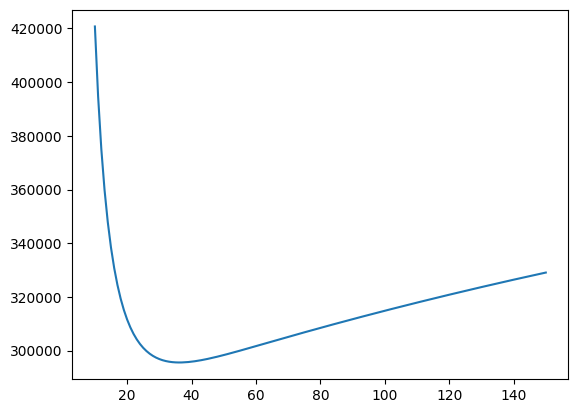

In [47]:
plt.plot(np.arange(10,151), sim_likes[9:])

# Cross-Validation

## Setup Splits

In [48]:
def convert_resp_inds(trial_nums):
    return np.repeat(trial_nums*3, 3) + np.tile(np.arange(3), 20)

In [49]:
world_inds = np.arange(40, dtype=int)
np.random.seed(1)
splits = np.zeros((100,40),dtype=int)

for i in range(100):
    shuf = np.random.permutation(world_inds)
    splits[i] = shuf

In [50]:
train = np.sort(splits[:,:20], axis=1)
test = np.sort(splits[:,20:], axis=1)

In [51]:
train_one = train[0]
convert_resp_inds(train_one)

array([  6,   7,   8,   9,  10,  11,  12,  13,  14,  30,  31,  32,  42,
        43,  44,  51,  52,  53,  57,  58,  59,  63,  64,  65,  66,  67,
        68,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 105,
       106, 107, 108, 109, 110, 117, 118, 119])

## Below Hole CV

In [52]:
spl_opts = []
for spl_num in range(train.shape[0]):
    train_set = train[spl_num]
    response_array_spl = response_array[convert_resp_inds(train_set)]
    opt = minimize_scalar(below_hole_neg_like, args=(response_array_spl), bounds=[1, 300])
    spl_opts.append(opt)

In [53]:
# Check whether all optimizations were successful
np.all([opt.success for opt in spl_opts])

True

In [54]:
below_hole_sds = [opt.x for opt in spl_opts]
below_hole_train_likes = [-opt.fun for opt in spl_opts]
below_hole_test_means = np.array(hole_pos*20)

In [55]:
below_hole_dists = [dist.pdf(np.arange(600)) for dist in create_below_hole_dists(below_hole_sds[0], hole_pos)]
ave_emd(below_hole_dists, human_kdes, world_nums[sorted(test[0])], "below_hole")

64.26635652833603

In [56]:
below_hole_test_likes = []
below_hole_test_r = []
below_hole_test_rmse = []
below_hole_test_emd = []
for i in range(100):
    test_set = test[i]
    response_array_spl = response_array[convert_resp_inds(test_set)]
    # Likelihood
    below_hole_like = -below_hole_neg_like(below_hole_sds[i], response_array_spl)
    below_hole_test_likes.append(below_hole_like)
    # r and RMSE
    human_test_means = np.mean(response_array_spl, axis=1)
    r = np.corrcoef(below_hole_test_means, human_test_means)[0,1]
    rmse = root_mean_squared_error(below_hole_test_means, human_test_means)
    below_hole_test_r.append(r)
    below_hole_test_rmse.append(rmse)
    # EMD
    below_hole_dists = [dist.pdf(np.arange(0,600)) for dist in create_below_hole_dists(below_hole_sds[i], hole_pos)]
    emd = ave_emd(below_hole_dists, human_kdes, world_nums[sorted(test[i])], "below_hole")
    below_hole_test_emd.append(emd)
    

In [57]:
df_cv_below_hole = pd.DataFrame({"split": np.arange(100, dtype=int),
                                 "sd": below_hole_sds,
                                 "train_like": below_hole_train_likes,
                                 "test_like": below_hole_test_likes,
                                 "test_r": below_hole_test_r,
                                 "test_rmse": below_hole_test_rmse,
                                 "test_emd": below_hole_test_emd})

In [58]:
df_cv_below_hole

,split,sd,train_like,test_like,test_r,test_rmse,test_emd
0,0,102.440678,-163302.005345,-161092.377378,0.869869,63.421894,64.266357
1,1,100.298745,-162731.476484,-161591.977599,0.851827,67.977855,67.116760
2,2,96.679401,-161739.150107,-162572.151282,0.826095,71.985347,69.111604
3,3,97.283838,-161907.428023,-162395.643326,0.821345,71.803547,68.249756
4,4,93.850404,-160937.294780,-163473.567494,0.817031,71.790495,67.128799
...,...,...,...,...,...,...,...
95,95,96.786829,-161769.135282,-162540.384513,0.849226,69.455153,66.839368
96,96,97.244973,-161896.638070,-162406.832220,0.836791,68.864047,66.699299
97,97,101.650342,-163092.892184,-161270.253002,0.857176,67.231627,66.528699
98,98,97.257198,-161900.034616,-162403.308282,0.848192,67.908136,66.015642


## Ground Truth CV

In [59]:
spl_opts = []
for spl_num in range(train.shape[0]):
    if spl_num % 10 == 0:
        print("Split:", spl_num)
    train_set = train[spl_num]
    train_ind = convert_resp_inds(train_set)
    response_array_spl = response_array[train_ind]
    train_gt_list = gt_list[train_ind]
    opt = minimize_scalar(gt_neg_like, args=(response_array_spl, train_gt_list), bracket=[1, 300])
    spl_opts.append(opt)

Split: 0
Split: 10
Split: 20
Split: 30
Split: 40
Split: 50
Split: 60
Split: 70
Split: 80
Split: 90


In [60]:
# Check whether all optimizations were successful
np.all([opt.success for opt in spl_opts])

True

In [61]:
gt_opt_sds = [opt.x for opt in spl_opts]
gt_train_likes = [-opt.fun for opt in spl_opts]

In [62]:
gt_test_likes = []
gt_test_r = []
gt_test_rmse = []
gt_test_emd = []
for i in range(100):
    test_set = test[i]
    test_ind = convert_resp_inds(test_set)
    response_array_spl = response_array[test_ind]
    test_gt_list = gt_list[test_ind]
    # Likelihood
    gt_like = -gt_neg_like(gt_opt_sds[i], response_array_spl, test_gt_list)
    gt_test_likes.append(gt_like)
    # r and RMSE
    human_test_means = np.mean(response_array_spl, axis=1)
    r = np.corrcoef(test_gt_list, human_test_means)[0,1]
    rmse = root_mean_squared_error(test_gt_list, human_test_means)
    gt_test_r.append(r)
    gt_test_rmse.append(rmse)
    # EMD
    # gt_dists = create_gt_dists(gt_opt_sds[i], test_gt_list)
    gt_test_pdfs = create_gt_pdfs(gt_opt_sds[i], gt_dict, world_nums[test_set])
    emd = ave_emd(gt_test_pdfs, human_kdes, world_nums[test_set], "ground_truth")
    gt_test_emd.append(emd)

In [63]:
df_cv_gt = pd.DataFrame({"split": np.arange(100, dtype=int),
                         "sd": gt_opt_sds,
                         "train_like": gt_train_likes,
                         "test_like": gt_test_likes,
                         "test_r": gt_test_r,
                         "test_rmse": gt_test_rmse,
                         "test_emd": gt_test_emd})

In [64]:
df_cv_gt

,split,sd,train_like,test_like,test_r,test_rmse,test_emd
0,0,97.695217,-162021.360415,-161121.408269,0.905235,64.451341,54.582273
1,1,92.908863,-160665.054518,-162523.545100,0.884833,72.323382,57.642623
2,2,94.890802,-161234.962947,-161900.536568,0.879301,68.603455,55.960276
3,3,92.812507,-160637.038706,-162555.479978,0.857830,72.025233,59.401594
4,4,80.085167,-156654.788688,-168495.190523,0.822830,82.036819,62.952013
...,...,...,...,...,...,...,...
95,95,97.429745,-161947.890931,-161190.367313,0.921823,62.298119,51.032866
96,96,93.429495,-160815.931335,-162353.693214,0.877722,68.203167,57.281893
97,97,96.040154,-161560.032599,-161567.396822,0.892603,69.361912,56.369471
98,98,85.458587,-158408.201449,-165517.790498,0.859899,77.131121,60.506102


# Create Noisy Sim Speadsheet

In [65]:
# bw_range = np.arange(10, 151, 10)

# df_noisy_sim = compute_ns_grid(model_files, bw_range, response_array, world_nums, kde_method="sklearn")
# df_noisy_sim.to_csv("grid_search/noisy_sim_like_grid.xz", index=False, compression="xz")

df_noisy_sim = pd.read_csv("grid_search/noisy_sim_like_grid.xz", compression="xz")

## Drop Noise Only

In [66]:
# Filter df_noisy_sim for only cases where cm == 1.0 and csd == 0.0
df_noisy_sim_dn = df_noisy_sim[(df_noisy_sim["cm"] == 1.0) & (df_noisy_sim["csd"] == 0.0)].reset_index(drop=True)   

In [67]:
df_noisy_sim_dn

,dn,cm,csd,bw,world,hole,trial_ind,log_prob
0,0.2,1.0,0.0,10,2,1,0,-11690.239132
1,0.2,1.0,0.0,10,2,2,0,-14622.564265
2,0.2,1.0,0.0,10,2,3,0,-7764.472731
3,0.2,1.0,0.0,10,6,1,1,-27135.266172
4,0.2,1.0,0.0,10,6,2,1,-6135.062661
...,...,...,...,...,...,...,...,...
19795,0.8,1.0,0.0,150,115,2,38,-2826.124527
19796,0.8,1.0,0.0,150,115,3,38,-2794.525195
19797,0.8,1.0,0.0,150,118,1,39,-2773.985337
19798,0.8,1.0,0.0,150,118,2,39,-2687.895963


In [68]:
df_noisy_sim_dn.groupby(["dn", "bw"]).mean().reset_index()[["dn", "bw", "log_prob"]].sort_values("log_prob", ascending=False)

,dn,bw,log_prob
51,0.3,70,-2630.014019
66,0.4,70,-2632.778036
50,0.3,60,-2633.139275
36,0.2,70,-2633.453517
81,0.5,70,-2634.399131
...,...,...,...
135,0.9,10,-8524.984543
120,0.8,10,-8536.102158
30,0.2,10,-8708.741474
15,0.1,10,-16062.195260


## Col Noise Only

In [69]:
# Filter df_noisy_sim for only cases where dn == 0.0
df_noisy_sim_cno = df_noisy_sim[df_noisy_sim["dn"] == 0.0].reset_index(drop=True)

In [70]:
df_noisy_sim_cno.groupby(["cm", "csd", "bw"]).mean().reset_index()[["cm", "csd", "bw", "log_prob"]].sort_values("log_prob", ascending=False)

,cm,csd,bw,log_prob
81,0.0,0.6,70,-2569.289953
216,0.1,0.5,70,-2569.381243
366,0.2,0.5,70,-2569.506222
231,0.1,0.6,70,-2570.718802
66,0.0,0.5,70,-2571.124259
...,...,...,...,...
150,0.1,0.1,10,-12720.005659
0,0.0,0.1,10,-13377.418780
1350,0.9,0.1,10,-13672.963309
1515,1.0,0.1,10,-14243.508323


## Full Model

In [71]:
df_noisy_sim.groupby(["dn", "cm", "csd", "bw"]).mean().reset_index()[["dn", "cm", "csd", "bw", "log_prob"]].sort_values("log_prob", ascending=False)

,dn,cm,csd,bw,log_prob
5088,0.3,0.0,0.7,40,-2465.658176
5373,0.3,0.2,0.6,40,-2467.900470
3423,0.2,0.0,0.7,40,-2468.578176
3588,0.2,0.1,0.8,40,-2468.988451
3858,0.2,0.3,0.6,40,-2469.176630
...,...,...,...,...,...
0,0.0,0.0,0.1,10,-13377.418780
1350,0.0,0.9,0.1,10,-13672.963309
1515,0.0,1.0,0.1,10,-14243.508323
3165,0.1,1.0,0.0,10,-16062.195260


In [72]:
def cross_val_ns(df_grid, train, test):

    """
    Using the df_grid, determine the best parameter setting for each set of train trials in train, and evaluate on test.
    Args:
    df_grid: DataFrame containing the grid predictions for all parameter settings
    train: Array of train trial indices
    test: Array of test trial indices
    Output:
    DataFrame containing the top parameters for each split and the evaluation metrics
    """

    out_dict = {
        "split": [],
        "dn": [],
        "cm": [],
        "csd": [],
        "bw": [],
        "train_like": [],
        "test_like": [],
        "test_r": [],
        "test_rmse": [],
        "test_emd": []
    }

    nsplits = train.shape[0]

    for spl in tqdm(range(nsplits)):
        train_world_ind = train[spl,:]

        test_world_ind = test[spl,:]
        test_world_num = world_nums[test_world_ind]
        test_trial_ind = convert_resp_inds(test_world_ind)

        df_train = df_grid[df_grid["trial_ind"].isin(train_world_ind)].reset_index(drop=True)
        df_test = df_grid[df_grid["trial_ind"].isin(test_world_ind)].reset_index(drop=True)

        df_top_train = df_train.groupby(["dn", "cm", "csd", "bw"]).sum().reset_index()[["dn", "cm", "csd", "bw", "log_prob"]].sort_values("log_prob", ascending=False)

        top_dn, top_cm, top_csd, top_bw, train_like = df_top_train.iloc[0].values

        df_test_opt_mod = df_test[(df_test["dn"] == top_dn) & (df_test["cm"] == top_cm) & (df_test["csd"] == top_csd) & (df_test["bw"] == top_bw)]
        test_like = df_test_opt_mod["log_prob"].sum()

        sim_file_path = f"grid_search/prediction_{top_dn}_drop_noise_{top_cm}_col_mean_{top_csd}_col_sd_100_sims.csv"
        df_top_sim = pd.read_csv(sim_file_path).drop("Unnamed: 0", axis=1)

        df_top_means = df_top_sim.groupby(["world", "hole"]).mean()["x_pos"].values

        human_test_means = human_mean_resp[test_trial_ind]
        model_test_means = df_top_means[convert_resp_inds(test[spl])]

        r = np.corrcoef(model_test_means, human_test_means)[0,1]
        rmse = root_mean_squared_error(model_test_means, human_test_means)

        model_kdes = compute_kdes(df_top_sim, "x_pos", top_bw)
        emd = ave_emd(model_kdes, human_kdes, test_world_num, "noisy_sim")

        out_dict["split"].append(spl)
        out_dict["dn"].append(top_dn)
        out_dict["cm"].append(top_cm)
        out_dict["csd"].append(top_csd)
        out_dict["bw"].append(top_bw)
        out_dict["train_like"].append(train_like)
        out_dict["test_like"].append(test_like)
        out_dict["test_r"].append(r)
        out_dict["test_rmse"].append(rmse)
        out_dict["test_emd"].append(emd)

    return pd.DataFrame(out_dict)
        

In [73]:
df_cv_dn = cross_val_ns(df_noisy_sim_dn, train, test)
df_cv_dn

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


,split,dn,cm,csd,bw,train_like,test_like,test_r,test_rmse,test_emd
0,0,0.6,1.0,0.0,70.0,-158222.018299,-157916.415582,0.946217,42.186911,49.863039
1,1,0.3,1.0,0.0,70.0,-157541.403802,-158060.278493,0.926734,53.094293,48.489271
2,2,0.2,1.0,0.0,60.0,-156674.392015,-160118.698013,0.900774,58.853839,46.808422
3,3,0.2,1.0,0.0,70.0,-156744.734354,-159269.687663,0.889321,60.170956,50.162298
4,4,0.2,1.0,0.0,70.0,-154846.664490,-161167.757527,0.876169,63.439419,51.500965
...,...,...,...,...,...,...,...,...,...,...
95,95,0.3,1.0,0.0,70.0,-157852.798563,-157748.883733,0.940737,47.627422,44.946024
96,96,0.3,1.0,0.0,70.0,-157537.703716,-158063.978580,0.925828,48.276504,47.869352
97,97,0.3,1.0,0.0,70.0,-158110.361638,-157491.320657,0.920479,53.412719,49.087230
98,98,0.2,1.0,0.0,60.0,-155411.220047,-161381.869981,0.894797,61.188704,49.832873


In [74]:
df_cv_cno = cross_val_ns(df_noisy_sim_cno, train, test)
df_cv_cno

100%|██████████| 100/100 [00:43<00:00,  2.28it/s]


,split,dn,cm,csd,bw,train_like,test_like,test_r,test_rmse,test_emd
0,0,0.0,0.0,0.6,70.0,-154008.518268,-154306.276130,0.979968,28.759658,32.023675
1,1,0.0,0.1,0.6,70.0,-154859.517317,-153626.738949,0.980641,28.095507,31.469367
2,2,0.0,0.0,0.6,70.0,-154851.733634,-153463.060764,0.989223,21.316300,27.762003
3,3,0.0,0.1,0.6,70.0,-154807.871429,-153678.384837,0.977100,27.260392,31.695699
4,4,0.0,0.0,0.6,70.0,-153187.804651,-155126.989746,0.977453,27.421336,30.913025
...,...,...,...,...,...,...,...,...,...,...
95,95,0.0,0.0,0.6,60.0,-152800.745667,-155967.601485,0.982539,29.319630,29.254445
96,96,0.0,0.1,0.5,70.0,-153479.945771,-154845.803364,0.979497,27.195013,31.022518
97,97,0.0,0.0,0.6,70.0,-154951.032690,-153363.761707,0.984104,27.571491,30.088069
98,98,0.0,0.0,0.6,60.0,-153023.806257,-155744.540895,0.980620,28.663239,29.649334


In [75]:
df_cv_ns = cross_val_ns(df_noisy_sim, train, test)
df_cv_ns

100%|██████████| 100/100 [01:02<00:00,  1.59it/s]


,split,dn,cm,csd,bw,train_like,test_like,test_r,test_rmse,test_emd
0,0,0.3,0.3,0.6,40.0,-148428.510939,-148044.035665,0.991313,17.226198,21.129003
1,1,0.3,0.0,0.7,40.0,-148587.561785,-147291.419338,0.994262,14.436679,19.345905
2,2,0.2,0.2,0.5,40.0,-147454.462343,-149794.484756,0.994516,14.382303,18.650524
3,3,0.3,0.1,0.8,40.0,-148839.295262,-147495.067862,0.986460,19.675598,24.630810
4,4,0.3,0.1,0.8,40.0,-147346.846442,-148987.516682,0.986720,18.958671,23.533492
...,...,...,...,...,...,...,...,...,...,...
95,95,0.2,0.0,0.7,40.0,-146520.733079,-149708.648076,0.992499,17.346781,20.464972
96,96,0.2,0.1,0.6,40.0,-148087.424969,-148587.332842,0.992992,15.483846,18.714652
97,97,0.2,0.1,0.8,40.0,-149143.015986,-147135.598167,0.988400,20.419879,21.230501
98,98,0.3,0.1,0.8,40.0,-147885.871969,-148448.491155,0.986887,19.699914,24.725104


In [76]:
df_cv_below_hole["model"] = "below_hole"
df_cv_gt["model"] = "ground_truth"
df_cv_dn["model"] = "drop_noise"
df_cv_cno["model"] = "col_noise"
df_cv_ns["model"] = "full_model"

# df_cv = pd.concat([])

## Load neural networks

In [77]:
with open("saved_model_pred/linear_w_pretraining_cvsplits.p", "rb") as f:
    linear_cvsplits = pickle.load(f)

with open("saved_model_pred/mlp_w_pretraining_cvsplits.p", "rb") as f:
    mlp_cvsplits = pickle.load(f)

with open("saved_model_pred/cnn_w_pretraining_cvsplits.p", "rb") as f:
    cnn_cvsplits = pickle.load(f)

linear_kde_dicts = [spl["kde_dicts"] for spl in linear_cvsplits]
mlp_kde_dicts = [spl["kde_dicts"] for spl in mlp_cvsplits]
cnn_kde_dicts = [spl["kde_dicts"] for spl in cnn_cvsplits]

In [78]:
def compute_mean_pred(world_nums, kde_dict):

    mean_pred = []

    for world_num in world_nums:
        for hole in [1,2,3]:
            mean_pred.append(np.sum(kde_dict[world_num][hole]*np.arange(600)))

    return mean_pred

def evaluate_nn(test_splits, kde_dicts, human_kdes, human_mean_resp, model):

    out_dict = {
        "model": [],
        "split": [],
        "train_like": [],
        "test_like": [],
        "test_r": [],
        "test_rmse": [],
        "test_emd": []
    }

    for i, split in enumerate(test_splits):

        test_worlds = world_nums[split]
        test_trial_ind = convert_resp_inds(split)

        model_kde_dict = kde_dicts[i]

        split_mean_pred = compute_mean_pred(test_worlds, model_kde_dict)
        split_human_means = human_mean_resp[test_trial_ind]

        r = np.corrcoef(split_mean_pred, split_human_means)[0,1]
        rmse = root_mean_squared_error(split_mean_pred, split_human_means)
        emd = ave_emd(model_kde_dict, human_kdes, test_worlds, model)

        out_dict["model"].append(model)
        out_dict["split"].append(i)
        out_dict["train_like"].append(None)
        out_dict["test_like"].append(None)
        out_dict["test_r"].append(r)
        out_dict["test_rmse"].append(rmse)
        out_dict["test_emd"].append(emd)

    df_out = pd.DataFrame(out_dict)

    df_out["train_like"] = df_out["train_like"].astype(float)
    df_out["test_like"] = df_out["test_like"].astype(float)

    return pd.DataFrame(out_dict)

In [79]:
df_cv_linear = evaluate_nn(test, linear_kde_dicts, human_kdes, human_mean_resp, "linear")
df_cv_linear

,model,split,train_like,test_like,test_r,test_rmse,test_emd
0,linear,0,None,None,0.776740,82.040383,73.269495
1,linear,1,None,None,0.724010,89.274847,80.984001
2,linear,2,None,None,0.731484,91.101392,81.202212
3,linear,3,None,None,0.728986,90.318380,80.868893
4,linear,4,None,None,0.693532,98.865971,85.005312
...,...,...,...,...,...,...,...
95,linear,95,None,None,0.658599,101.073078,90.069156
96,linear,96,None,None,0.739819,88.395397,84.318560
97,linear,97,None,None,0.660265,97.103373,85.187477
98,linear,98,None,None,0.777290,89.093732,78.823823


In [80]:
df_cv_mlp = evaluate_nn(test, mlp_kde_dicts, human_kdes, human_mean_resp, "mlp")
df_cv_mlp

,model,split,train_like,test_like,test_r,test_rmse,test_emd
0,mlp,0,None,None,0.851593,66.932864,63.971402
1,mlp,1,None,None,0.747658,86.176993,74.290858
2,mlp,2,None,None,0.812062,76.560454,69.243119
3,mlp,3,None,None,0.805603,72.920694,65.189770
4,mlp,4,None,None,0.784622,77.988327,69.114271
...,...,...,...,...,...,...,...
95,mlp,95,None,None,0.819678,78.112369,69.865473
96,mlp,96,None,None,0.800715,78.762813,70.641002
97,mlp,97,None,None,0.729246,90.358167,79.444285
98,mlp,98,None,None,0.775353,80.444009,72.286712


In [81]:
df_cv_cnn = evaluate_nn(test, cnn_kde_dicts, human_kdes, human_mean_resp, "cnn")
df_cv_cnn

,model,split,train_like,test_like,test_r,test_rmse,test_emd
0,cnn,0,None,None,0.973889,29.871508,26.625820
1,cnn,1,None,None,0.975057,28.744175,27.996781
2,cnn,2,None,None,0.978096,25.560720,22.919213
3,cnn,3,None,None,0.965465,32.664008,28.881993
4,cnn,4,None,None,0.972350,27.315150,28.293579
...,...,...,...,...,...,...,...
95,cnn,95,None,None,0.957591,38.629314,33.701389
96,cnn,96,None,None,0.981920,22.800519,24.542931
97,cnn,97,None,None,0.976043,28.078150,25.871432
98,cnn,98,None,None,0.972864,30.653499,28.024333


In [82]:
df_cv = pd.concat([
    df_cv_below_hole[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]],
    df_cv_gt[["model", "split", "train_like", "test_like",  "test_r", "test_rmse", "test_emd"]],
    df_cv_linear[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]],
    df_cv_mlp[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]],
    df_cv_cnn[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]],
    df_cv_dn[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]],
    df_cv_cno[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]],
    df_cv_ns[["model", "split", "train_like", "test_like", "test_r", "test_rmse", "test_emd"]]
])

/var/folders/z6/gkd0j5yd26dggs87_gwykt5r0000gp/T/ipykernel_84427/2735539324.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_cv = pd.concat([


In [83]:
df_cv

,model,split,train_like,test_like,test_r,test_rmse,test_emd
0,below_hole,0,-163302.005345,-161092.377378,0.869869,63.421894,64.266357
1,below_hole,1,-162731.476484,-161591.977599,0.851827,67.977855,67.116760
2,below_hole,2,-161739.150107,-162572.151282,0.826095,71.985347,69.111604
3,below_hole,3,-161907.428023,-162395.643326,0.821345,71.803547,68.249756
4,below_hole,4,-160937.294780,-163473.567494,0.817031,71.790495,67.128799
...,...,...,...,...,...,...,...
95,full_model,95,-146520.733079,-149708.648076,0.992499,17.346781,20.464972
96,full_model,96,-148087.424969,-148587.332842,0.992992,15.483846,18.714652
97,full_model,97,-149143.015986,-147135.598167,0.988400,20.419879,21.230501
98,full_model,98,-147885.871969,-148448.491155,0.986887,19.699914,24.725104


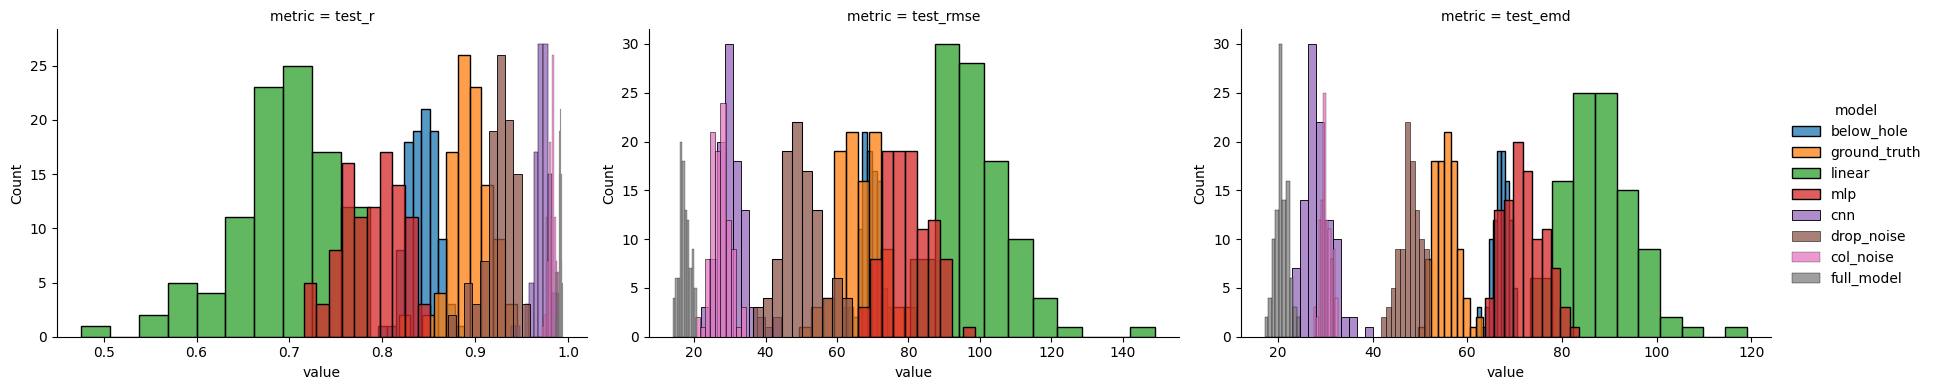

In [84]:
df_melted = df_cv.melt(id_vars='model', value_vars=['test_r', 'test_rmse', 'test_emd'], 
                    var_name='metric', value_name='value')

# Create the FacetGrid
g = sns.FacetGrid(df_melted, col='metric', hue='model', sharex=False, sharey=False, height=4, aspect=1.5)
g.map(sns.histplot, 'value', kde=False, bins=10, edgecolor='black')

g.add_legend()

In [85]:
# Define a function to compute the 2.5th percentile
def percentile_2pt5(x):
    return x.quantile(0.025)

# Define a function to compute the 97.5th percentile
def percentile_97pt5(x):
    return x.quantile(0.975)

# Group by 'model' and compute the median, 2.5th percentile, and 97.5th percentile for each metric
df_cv_result = df_cv.groupby('model').agg(
    test_r_median=('test_r', 'median'),
    test_r_percentile_2pt5=('test_r', percentile_2pt5),
    test_r_percentile_97pt5=('test_r', percentile_97pt5),
    test_rmse_median=('test_rmse', 'median'),
    test_rmse_percentile_2pt5=('test_rmse', percentile_2pt5),
    test_rmse_percentile_97pt5=('test_rmse', percentile_97pt5),
    test_emd_median=('test_emd', 'median'),
    test_emd_percentile_2pt5=('test_emd', percentile_2pt5),
    test_emd_percentile_97pt5=('test_emd', percentile_97pt5)
).reset_index()

df_cv_result['model'] = pd.Categorical(df_cv_result['model'], categories=["full_model", "drop_noise", "col_noise", "ground_truth", "below_hole", "linear", "mlp", "cnn"], ordered=True)

# Sort the DataFrame by the 'model' column
df_cv_result_sorted = df_cv_result.sort_values('model').reset_index(drop=True)

df_cv_result_sorted.round(2)

,model,test_r_median,test_r_percentile_2pt5,test_r_percentile_97pt5,test_rmse_median,test_rmse_percentile_2pt5,test_rmse_percentile_97pt5,test_emd_median,test_emd_percentile_2pt5,test_emd_percentile_97pt5
0,full_model,0.99,0.99,0.99,17.29,14.53,20.39,20.62,18.43,23.60
1,drop_noise,0.93,0.89,0.95,49.35,39.28,63.18,47.85,43.20,51.60
2,col_noise,0.98,0.98,0.99,27.34,22.73,32.70,30.03,28.08,32.35
3,ground_truth,0.89,0.85,0.93,66.21,53.21,78.82,55.32,51.08,61.20
4,below_hole,0.84,0.82,0.87,69.24,63.20,73.81,67.19,62.91,70.14
5,linear,0.70,0.57,0.78,96.91,82.24,118.09,87.33,75.61,101.69
6,mlp,0.79,0.72,0.84,79.52,69.62,90.49,71.59,65.02,80.43
7,cnn,0.97,0.95,0.98,30.07,24.49,39.64,28.06,23.90,34.46


In [109]:
df_cv_comp = df_cv[["model", "split", "test_r", "test_rmse", "test_emd"]]
# pivot df_cv_comp wider so that each model has its own test_r, test_rmse, and test_emd columns
df_cv_comp_wide = df_cv_comp.pivot(index="split", columns="model")

# for each test test metric, compute the difference between the full model and each other model
test_metrics = ['test_r', 'test_rmse', 'test_emd']
models = ["below_hole", "cnn", "col_noise", "drop_noise", "full_model", "ground_truth", "linear", "mlp"]

# Initialize a dictionary to store the differences
differences = {}

# Compute the differences for each test metric
for metric in test_metrics:
    # Extract the columns for the current metric
    metric_df = df_cv_comp_wide[metric]
    
    # Compute the differences
    if metric == 'test_r':
        # For test_r, subtract the other models from the full_model
        diff_df = metric_df['full_model'].values[:, None] - metric_df.drop(columns=['full_model']).values
    else:
        # For test_rmse and test_emd, subtract the full_model from the other models
        diff_df = metric_df.drop(columns=['full_model']).values - metric_df['full_model'].values[:, None]
    
    # Store the differences in the dictionary
    differences[metric] = pd.DataFrame(diff_df, columns=[f'{metric}_diff_{model}' for model in models if model != 'full_model'])

# Concatenate the differences into a single DataFrame
df_differences = pd.concat(differences.values(), axis=1)

In [99]:
df_differences_summary = df_differences.agg(["median", percentile_2pt5, percentile_97pt5]).T.reset_index()
df_differences_summary.columns = ["comparison", "median", "percentile_2.5", "percentile_97.5"]
df_differences_summary["metric"] = df_differences_summary["comparison"].apply(lambda x: x.split("_")[1])
df_differences_summary["model"] = df_differences_summary["comparison"].apply(lambda x: "_".join(x.split("_")[2:]).replace("diff_", ""))
# df_differences_summary = df_differences_summary.sort_values(by=["model", "metric"], key=lambda col: col.map({"r": 0, "rmse": 1, "emd": 2} if col.name == "metric" else col))
# Define the custom order for metric
metric_order = ['r', 'rmse', 'emd']
df_differences_summary['metric'] = pd.Categorical(df_differences_summary['metric'], categories=metric_order, ordered=True)

# Sort by model and then by metric
df_differences_summary = df_differences_summary.sort_values(['model', 'metric'])
df_differences_summary.round(2)

,comparison,median,percentile_2.5,percentile_97.5,metric,model
0,test_r_diff_below_hole,0.15,0.12,0.18,r,below_hole
7,test_rmse_diff_below_hole,52.11,45.03,57.78,rmse,below_hole
14,test_emd_diff_below_hole,46.39,41.41,50.46,emd,below_hole
1,test_r_diff_cnn,0.02,0.01,0.04,r,cnn
8,test_rmse_diff_cnn,14.66,7.96,24.11,rmse,cnn
15,test_emd_diff_cnn,9.42,3.26,18.56,emd,cnn
2,test_r_diff_col_noise,0.01,0.00,0.02,r,col_noise
9,test_rmse_diff_col_noise,9.89,5.22,15.10,rmse,col_noise
16,test_emd_diff_col_noise,9.36,6.79,12.10,emd,col_noise
3,test_r_diff_drop_noise,0.06,0.04,0.10,r,drop_noise


In [93]:
df_differences_summary

,comparison,median,percentile_2.5,percentile_97.5
0,test_r_diff_below_hole,0.147923,0.119385,0.175085
1,test_r_diff_cnn,0.021290,0.008193,0.043111
2,test_r_diff_col_noise,0.008867,0.002145,0.015160
3,test_r_diff_drop_noise,0.064865,0.039781,0.097988
4,test_r_diff_ground_truth,0.095655,0.060317,0.143492
5,test_r_diff_linear,0.286414,0.211960,0.424077
6,test_r_diff_mlp,0.201406,0.154151,0.269492
7,test_rmse_diff_below_hole,52.105632,45.029656,57.776832
8,test_rmse_diff_cnn,14.655218,7.958952,24.114005
9,test_rmse_diff_col_noise,9.890602,5.218962,15.096924


In [118]:
cv_splits = {
    "train": train,
    "test": test,
    "key": list(zip(world_inds, world_nums))
}

In [119]:
with open("cv_splits.pkl", "wb") as f:
    pickle.dump(cv_splits, f)